## This script is the start of trying to determine how identify which issued bonds (rows) are most similar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
from sklearn.cluster import AgglomerativeClustering

## Load data

In [4]:
bonds = pd.read_csv('bond_similarity.csv', parse_dates=['Maturity'])
print(bonds.shape)
bonds.head()

(1211, 39)


,Cusip,ISIN,Description,Ticker,Coupon,Maturity,Composite Rating,Currency,Country,Sector Level 1,...,Prior Month-End Effective Duration,Prior Month-End Effective Yield,Prior Month-End OAS vs Govt,TRR % MTD LOC,Excess Rtn % MTD,Asset Swap Spread,Prior Month-End Asset Swap Spread,OAS vs Swap,Prior Month-End OAS vs Swap,Illiquidity Premium
0,'AL319313',XS1529687870,AA Bond Co Limited,AABOND,2.875,2022-01-31,BBB3,GBP,GB,Securitized/Collateralized,...,3.266,4.221,331.0,0.184,0.068,235.0,285.0,243.0,294.0,NaN
1,'AO236287',XS1645315620,AA Bond Co Limited,AABOND,2.750,2023-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,4.604,4.204,318.0,0.207,0.071,267.0,267.0,282.0,282.0,NaN
2,'AT538379',XS1856940462,AA Bond Co Limited,AABOND,4.875,2024-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,5.168,4.688,360.0,0.193,0.042,323.0,323.0,327.0,327.0,NaN
3,'EJ733791',XS0949169923,AA Bond Co Limited,AABOND,6.269,2025-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,5.728,4.705,354.0,0.273,0.107,433.0,335.0,418.0,324.0,NaN
4,'EJ944681',XS0996575378,AA Bond Co Limited,AABOND,4.249,2020-07-31,BBB3,GBP,GB,Securitized/Collateralized,...,1.892,3.549,278.0,0.284,0.202,137.0,244.0,136.0,243.0,NaN


In [5]:
bonds.columns

Index(['Cusip', 'ISIN', 'Description', 'Ticker', 'Coupon', 'Maturity',
       'Composite Rating', 'Currency', 'Country', 'Sector Level 1',
       'Sector Level 2', 'Sector Level 3', 'Sector Level 4', 'Type',
       'Face Value', 'Price', 'Accrued Interest', '% Weight', 'Cash',
       'Duration To Worst', 'Yield to Worst', 'Effective Duration',
       'Effective Yield', 'OAS vs Govt', 'Prior Month-End Price',
       'Prior Month-End Accrued Interest', 'Prior Month-End % Weight',
       'Prior Month-End Duration To Worst', 'Prior Month-End Yield To Worst',
       'Prior Month-End Effective Duration', 'Prior Month-End Effective Yield',
       'Prior Month-End OAS vs Govt', 'TRR % MTD LOC', 'Excess Rtn % MTD',
       'Asset Swap Spread', 'Prior Month-End Asset Swap Spread',
       'OAS vs Swap ', 'Prior Month-End OAS vs Swap', 'Illiquidity Premium'],
      dtype='object')

In [6]:
numeric_columns = bonds.describe().columns.tolist()
numeric_columns.remove('Illiquidity Premium')
numeric_columns.append('Maturity In Years')

# Explore Data

In [7]:
bonds['Composite Rating'].value_counts()

BBB1    245
A3      171
AAA     158
BBB2    148
A2      123
AA3     107
A1       98
BBB3     80
AA2      57
AA1      22
CASH      1
B1        1
Name: Composite Rating, dtype: int64

In [8]:
bonds['Type'].value_counts()

SENR    745
SSEN    152
SECR    124
T2       43
SUB      43
JSUB     22
T1        9
SSUB      8
CASH      1
UT2       1
Name: Type, dtype: int64

In [9]:
bonds.isnull().sum().sort_values(ascending=False).head(20)

Illiquidity Premium                   1150
Prior Month-End OAS vs Govt             64
Prior Month-End Accrued Interest        64
Prior Month-End % Weight                64
Prior Month-End Duration To Worst       64
Prior Month-End Effective Duration      64
Prior Month-End Effective Yield         64
Prior Month-End Yield To Worst          64
Prior Month-End Asset Swap Spread       64
Prior Month-End OAS vs Swap             64
Sector Level 3                          63
Sector Level 2                          63
Cash                                    63
Sector Level 1                          63
Ticker                                  63
Sector Level 4                          63
Type                                    63
Face Value                              63
Accrued Interest                        63
% Weight                                63
dtype: int64

In [10]:
bonds[~bonds['Prior Month-End Yield To Worst'].isnull()].isnull().sum().sort_values(ascending=False).head()

Illiquidity Premium    1147
Sector Level 1            0
Accrued Interest          0
Price                     0
Face Value                0
dtype: int64

In [12]:
bonds_clean = bonds[~bonds['Prior Month-End Yield To Worst'].isnull()].copy()
bonds_clean = bonds_clean.drop('Illiquidity Premium', axis=1)

In [13]:
bonds_clean['Sector Level 2'].value_counts()

Industrials                   392
Financial                     263
Quasi & Foreign Government    177
Securitized                   155
Utility                       128
Covered                        32
Name: Sector Level 2, dtype: int64

In [14]:
bonds_clean['Maturity In Years'] = (bonds_clean['Maturity'] - pd.Timestamp.today()) / np.timedelta64(1, 'Y')

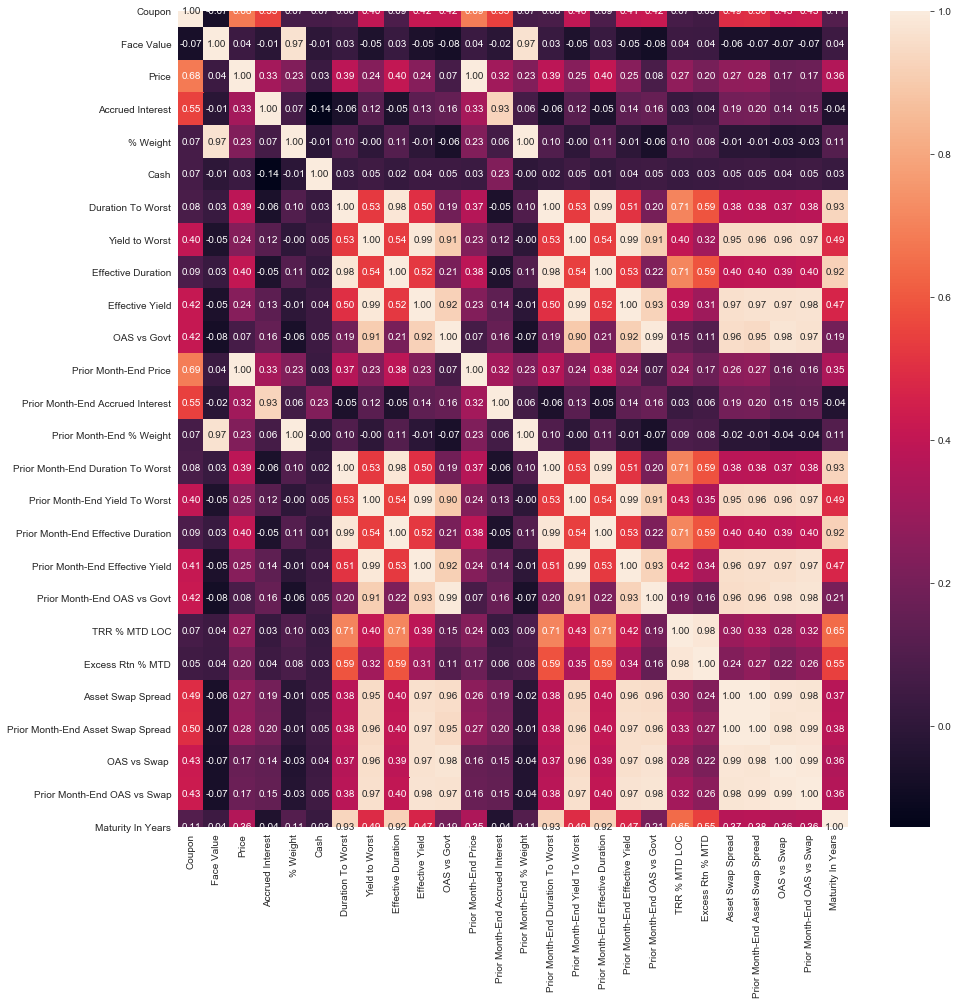

In [16]:
fig, ax0 = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(bonds_clean[numeric_columns].corr(), annot=True, fmt=".2f", ax=ax0)

# First attempt
* take only numeric columns
* use cosine similarity to compare bonds

In [17]:
bonds_clean_numeric = bonds_clean[numeric_columns].copy()

In [18]:
cos_sim_all = cosine_similarity(bonds_clean_numeric)

In [19]:
cos_sim_all.shape

(1147, 1147)

In [20]:
df_cos_sim = pd.DataFrame(cos_sim_all, columns=bonds_clean_numeric.index, index=bonds_clean_numeric.index)

In [21]:
# Most similar to the first bond is 57th
df_cos_sim.iloc[0, 1:].idxmax()

57

In [61]:
bonds_clean.loc[[0,57], :].T ## not great

,0,57
Cusip,'AL319313','AP513261'
ISIN,XS1529687870,XS1700429308
Description,AA Bond Co Limited,Aroundtown Property Holdings PLC
Ticker,AABOND,ARNDTN
Coupon,2.875,3
Maturity,2022-01-31 00:00:00,2029-10-16 00:00:00
Composite Rating,BBB3,BBB1
Currency,GBP,GBP
Country,GB,DE
Sector Level 1,Securitized/Collateralized,Corporate


# Second attempt
* Select subset of "important" numerical and categorical
* Stadardize them
* Use cosine similarity

In [24]:
bonds_clean_mixed = bonds_clean.loc[:,['Maturity In Years', 'Duration To Worst', 'OAS vs Swap ', 'Price', 'Prior Month-End OAS vs Swap', 'Coupon']].copy()

In [25]:
bonds_clean_mixed = bonds_clean_mixed.join(pd.get_dummies(bonds_clean[['Type', 'Composite Rating', 'Sector Level 2']]))

In [26]:
scaler0 = StandardScaler()
bonds_clean_mixed_std = pd.DataFrame(scaler0.fit_transform(bonds_clean_mixed), index=bonds_clean_mixed.index)

In [70]:
bonds_clean_mixed.head()

,Maturity In Years,Duration To Worst,OAS vs Swap,Price,Prior Month-End OAS vs Swap,Coupon,Type_JSUB,Type_SECR,Type_SENR,Type_SSEN,...,Composite Rating_AAA,Composite Rating_BBB1,Composite Rating_BBB2,Composite Rating_BBB3,Sector Level 2_Covered,Sector Level 2_Financial,Sector Level 2_Industrials,Sector Level 2_Quasi & Foreign Government,Sector Level 2_Securitized,Sector Level 2_Utility
0,1.997706,3.233,243.0,97.37418,294.0,2.875,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,3.492603,4.570,282.0,93.62339,282.0,2.750,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,4.494677,5.125,327.0,100.99960,327.0,4.875,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,5.494013,5.676,418.0,109.37700,324.0,6.269,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.494595,1.867,136.0,103.41360,243.0,4.249,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


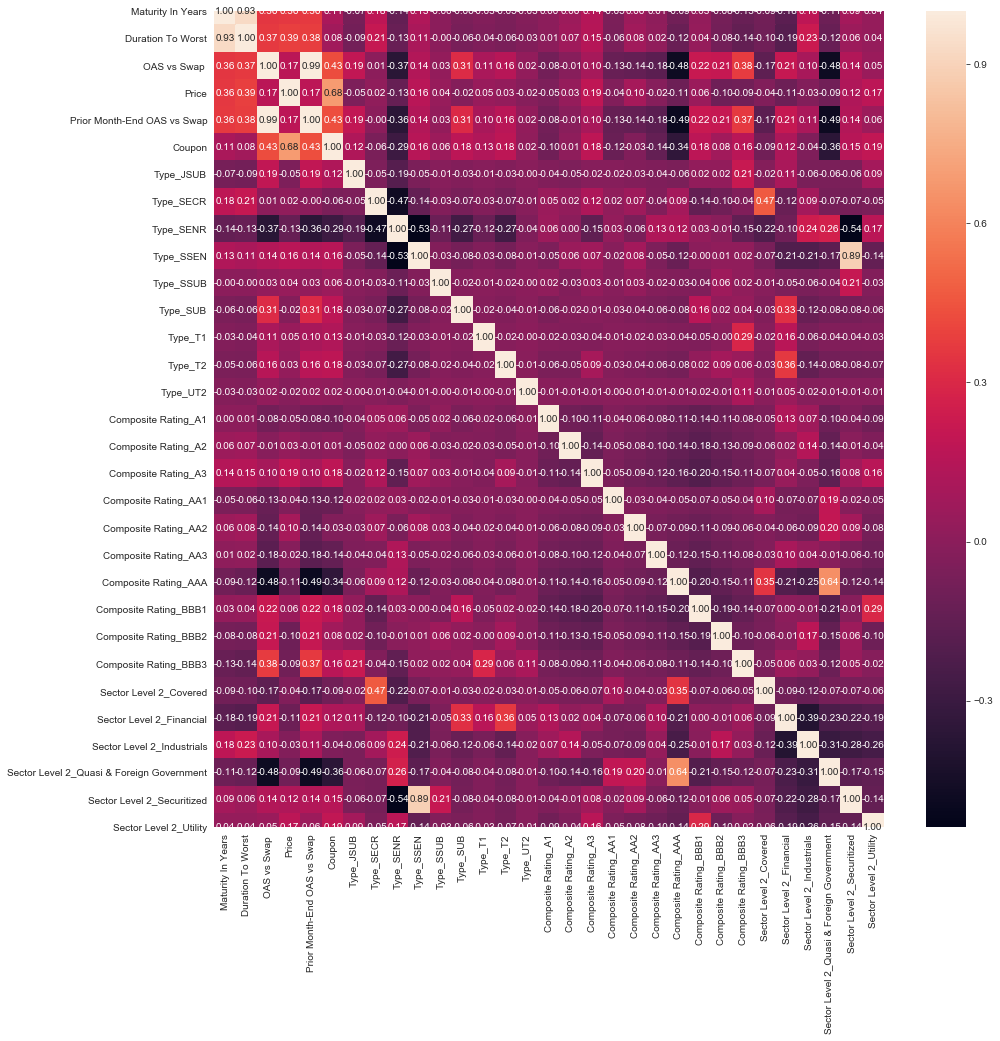

In [71]:
fig, ax0 = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(bonds_clean_mixed.corr(), annot=True, fmt=".2f", ax=ax0)

In [27]:
df_cos_sim2 = pd.DataFrame(cosine_similarity(bonds_clean_mixed_std), columns=bonds_clean_mixed.index, index=bonds_clean_mixed.index)

In [72]:
df_cos_sim2.iloc[0,1:].idxmax()

1

In [74]:
df_cos_sim2.iloc[0,2:].idxmax()

857

In [75]:
bonds_clean.loc[[0,1, 857], :].T ## Better, not great

,0,1,857
Cusip,'AL319313','AO236287','JK936494'
ISIN,XS1529687870,XS1645315620,XS1404980846
Description,AA Bond Co Limited,AA Bond Co Limited,RAC BOND CO PLC
Ticker,AABOND,AABOND,RACLN
Coupon,2.875,2.75,4.565
Maturity,2022-01-31 00:00:00,2023-07-31 00:00:00,2023-05-06 00:00:00
Composite Rating,BBB3,BBB3,BBB3
Currency,GBP,GBP,GBP
Country,GB,GB,GB
Sector Level 1,Securitized/Collateralized,Securitized/Collateralized,Securitized/Collateralized


# Third Attempt
* Use PCA to extract important variables
* DO NOT FORGET TO STANDARDIZE VARIABLES BEFORE PCA!!!
* The rest same as  before

In [84]:
bonds_clean_mixed_std.shape

(1147, 31)

In [82]:
pca2 = PCA(n_components=24)
bonds_clean_mixed_std_pca = pca2.fit_transform(bonds_clean_mixed_std)

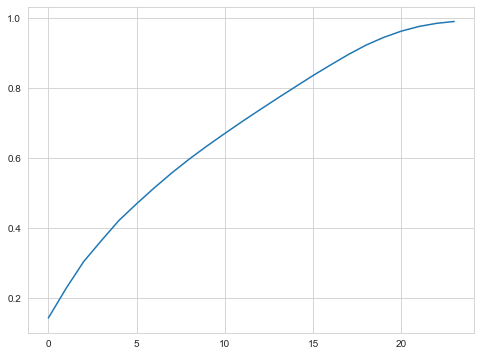

In [83]:
fig, ax0 = plt.subplots(1,1,figsize=(8,6))
ax0.plot(np.cumsum(pca2.explained_variance_ratio_))

In [85]:
bonds_clean_mixed_std_pca = pd.DataFrame(data=bonds_clean_mixed_std_pca, 
                                         index=bonds_clean_mixed_std.index, columns=['PC'+str(i+1) for i in range(24)])

In [86]:
clustering3 = AgglomerativeClustering(n_clusters=5).fit(bonds_clean_mixed_std_pca)

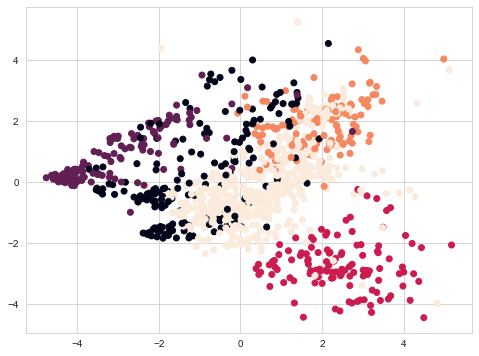

In [87]:
fig, ax0 = plt.subplots(1,1,figsize=(8,6))
ax0.scatter(bonds_clean_mixed_std_pca['PC1'], bonds_clean_mixed_std_pca['PC2'], c=clustering3.labels_)

In [88]:
df_cos_sim3 = pd.DataFrame(cosine_similarity(bonds_clean_mixed_std_pca), columns=bonds_clean_mixed_std_pca.index, index=bonds_clean_mixed_std_pca.index)

In [100]:
df_cos_sim3.iloc[42,~df_cos_sim3.columns.isin([42,222,221,223])].idxmax()

870

In [101]:
bonds_clean.loc[[42,222,221,870], :].T

,42,222,221,870
Cusip,'AM532556','AQ831262','AN740966','EC069624'
ISIN,XS1570025111,FR0013311743,FR0013260734,XS0092663649
Description,Province of Alberta,Caisse des Depots et Consignations,Caisse des Depots et Consignations,SNCF Reseau
Ticker,ALTA,CDCEPS,CDCEPS,RESFER
Coupon,1,1,0.5,5.5
Maturity,2021-11-15 00:00:00,2021-01-25 00:00:00,2020-06-12 00:00:00,2021-12-01 00:00:00
Composite Rating,AA2,AA2,AA2,AA2
Currency,GBP,GBP,GBP,GBP
Country,CA,FR,FR,FR
Sector Level 1,Quasi & Foreign Government,Quasi & Foreign Government,Quasi & Foreign Government,Quasi & Foreign Government
